**Linear regression by pixel, cleaned up version of exploration 0.**

In [14]:
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import h5py
import matplotlib.animation as animation
from sklearn.linear_model import LinearRegression

In [15]:
dataset_location = '../dataset/' # put the root or relative path to your dataset here

In [16]:
scene_df = pd.read_hdf(dataset_location + 'scene.hdf5')
calibration_df = pd.read_hdf(dataset_location + 'calibration_set_2.hdf5')

In [17]:
# Function to estimate offset and responsivity
def estimate_parameters(calibration_images, calibration_temperatures):
    height, width = calibration_images[0].shape
    num_pixels = height * width
    
    # Reshape images for linear regression
    images_reshaped = np.array([img.ravel() for img in calibration_images])
    
    offsets = np.zeros(num_pixels)
    responsivities = np.zeros(num_pixels)
    
    for i in range(num_pixels):
        model = LinearRegression().fit(calibration_temperatures.reshape(-1, 1), images_reshaped[:, i])
        offsets[i] = model.intercept_
        responsivities[i] = model.coef_[0]
    
    # Reshape back to original image shape
    offsets = offsets.reshape(height, width)
    responsivities = responsivities.reshape(height, width)
    
    return offsets, responsivities

In [18]:
# Ensure all images are correctly typed
scene_df['image'] = scene_df['image'].apply(lambda img: img.astype(np.float32))
calibration_df['image'] = calibration_df['image'].apply(lambda img: img.astype(np.float32))

# Process each scene image
calibration_images = calibration_df['image'].values
calibration_temperatures = calibration_df['t_fpa'].values

offset, gain = estimate_parameters(calibration_images, calibration_temperatures)

In [19]:
# Define the correction function
def apply_gain_offset_correction(image, gain, offset):
    return -((image - offset) /gain)

# Extract scene images
scene_images = np.stack(scene_df['image'].values)

# Apply the correction to each pixel of each scene image
corrected_scene_images = np.array([apply_gain_offset_correction(img, gain, offset) for img in scene_images])

# Output the shape of the corrected scene images
print("Corrected scene images shape:", corrected_scene_images.shape)

/var/folders/54/hy0k25rj3qq6wl3dn1jrwph00000gq/T/ipykernel_53373/2869704320.py:3: RuntimeWarning: invalid value encountered in divide
  return -((image - offset) /gain)


Corrected scene images shape: (400, 480, 640)


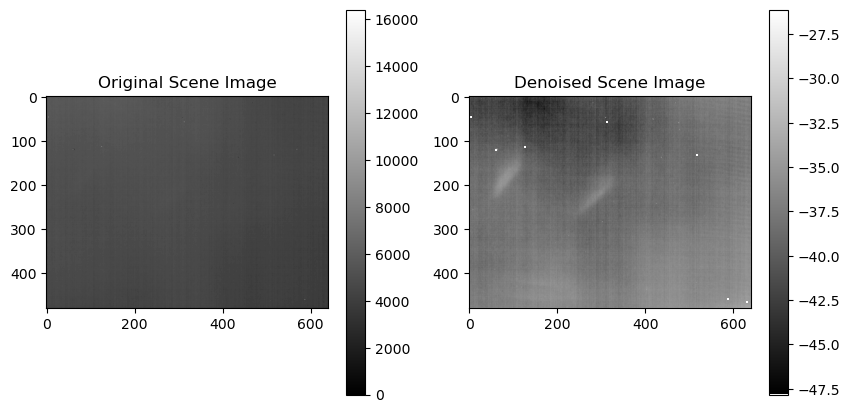

In [20]:
index = 15  # Index of the image to display

plt.figure(figsize=(10, 5))

# Original scene image
plt.subplot(1, 2, 1)
plt.title("Original Scene Image")
plt.imshow(scene_df['image'][index], cmap='gray')
plt.colorbar()

# Denoised scene image
plt.subplot(1, 2, 2)
plt.title("Denoised Scene Image")
plt.imshow(corrected_scene_images[index], cmap='gray')
plt.colorbar()

plt.show()

In [21]:
def save_video_from_images(images, output_filename, fps=60):
    """
    Save a sequence of images as a video.

    Parameters:
    images (list or array): List or array of images (each image should be a 2D or 3D NumPy array).
    output_filename (str): Output video filename (e.g., 'output.avi').
    fps (int): Frames per second for the video.
    """
    # Get the dimensions of the images
    height, width = images[0].shape[:2]

    # Define the codec and create VideoWriter object
    fourcc = cv2.VideoWriter_fourcc(*'XVID')
    out = cv2.VideoWriter(output_filename, fourcc, fps, (width, height))

    for img in images:
        # Ensure image is in the correct format (uint8)
        img_uint8 = cv2.normalize(img, None, 0, 255, cv2.NORM_MINMAX).astype('uint8')
        # If the image is grayscale, convert it to BGR
        if len(img_uint8.shape) == 2:
            img_uint8 = cv2.cvtColor(img_uint8, cv2.COLOR_GRAY2BGR)
        out.write(img_uint8)

    # Release everything when the job is finished
    out.release()

output_filename = 'output-pixel-lr.avi'
save_video_from_images(corrected_scene_images, output_filename)

/var/folders/54/hy0k25rj3qq6wl3dn1jrwph00000gq/T/ipykernel_53373/3821169032.py:19: RuntimeWarning: invalid value encountered in cast
  img_uint8 = cv2.normalize(img, None, 0, 255, cv2.NORM_MINMAX).astype('uint8')
